# validation

In [1]:
#!/bin/python
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import sklearn.model_selection
from sklearn.preprocessing import LabelEncoder
import pickle
import xgboost as xgb
#import tensorflow as tf
import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, precision_score, accuracy_score
import os.path

from xgboost import XGBClassifier

In [2]:
# param
import pickle

# parameters
parameters = {"learning_rate"    : [0.01, 0.10, 0.25, 0.5, 1 ],
    "max_depth"        : [ 3, 4, 5, 6, 7],
    "min_child_weight" : [ 1, 3, 5, 7 ],
    "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }


output_dir = "/ysm-gpfs/pi/zhao/zy92/projects/ddipred/ddi_pred/code/xgboost/output_round_100_cv//"
model_dict = {}
count = 0
for i in range(4):
    for j in range(5):
        print("INFO: " + "processing number" + str(count + 1))
        learning_rate = parameters["learning_rate"][i]
        max_depth = parameters["max_depth"][j]
        count += 1
        history_path = output_dir + "_lr_" + str(learning_rate) + "_md_" + str(max_depth) + "_history_dict.pickle"
        history_fo = open(history_path, "rb")
        history_dict = pickle.load(history_fo)
        # load the object from the file into var b
        model_dict[count] = {'history': history_dict}
        history_fo.close()

INFO: processing number1
INFO: processing number2
INFO: processing number3
INFO: processing number4
INFO: processing number5
INFO: processing number6
INFO: processing number7
INFO: processing number8
INFO: processing number9
INFO: processing number10
INFO: processing number11
INFO: processing number12
INFO: processing number13
INFO: processing number14
INFO: processing number15
INFO: processing number16
INFO: processing number17
INFO: processing number18
INFO: processing number19
INFO: processing number20


In [4]:
# param

# parameters
parameters = {"learning_rate"    : [0.10, 0.25, 0.5],
    "max_depth"        : [ 3, 4, 5, 6, 7],
    "min_child_weight" : [ 1, 3, 5, 7 ],
    "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }


output_dir = "/ysm-gpfs/pi/zhao/zy92/projects/ddipred/ddi_pred/code/xgboost/output_round_100/"
model_dict = {}
count = 0
for i in range(3):
    for j in range(5):
        print("INFO: " + "processing number" + str(count + 1))
        learning_rate = parameters["learning_rate"][i]
        max_depth = parameters["max_depth"][j]
        count += 1
        history_path = output_dir + "_lr_" + str(learning_rate) + "_md_" + str(max_depth) + "_history_dict.pickle"
        model_path = output_dir + "_lr_" + str(learning_rate) + "_md_" + str(max_depth) + "_xgb.pickle"
        history_fo = open(history_path, "rb")
        model_fo = open(model_path, "rb")
        history_dict = pickle.load(history_fo)
        bst = pickle.load(model_fo)
        # load the object from the file into var b
        model_dict[count] = {'model': bst,
                             'history': history_dict}
        history_fo.close()
        model_fo.close()

INFO: processing number1
INFO: processing number2
INFO: processing number3
INFO: processing number4
INFO: processing number5
INFO: processing number6
INFO: processing number7
INFO: processing number8
INFO: processing number9
INFO: processing number10
INFO: processing number11
INFO: processing number12
INFO: processing number13
INFO: processing number14
INFO: processing number15


In [7]:
bst_model = model_dict[9]["model"]

In [8]:
str(bst_model)

'<xgboost.core.Booster object at 0x2ac87a4bca90>'

In [ ]:
# similarity profile loading

In [9]:
# set directory
os.getcwd()
os.chdir("/ysm-gpfs/pi/zhao/zy92/projects/ddipred/ddi_pred/data")

# list of desired DDI Types
desired_DDI = [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 18, 19, 20, 21, 22, 26, 28, 30, 31, 32, 38, 40, 41, 43, 44, 45,
               49, 50, 51, 52, 54, 55, 62, 67, 68, 72, 74, 76, 78, 79, 80, 81]


# parameters
parameters = {"learning_rate"    : [0.01, 0.10, 0.25, 0.5, 1 ],
    "max_depth"        : [ 3, 4, 5, 6, 7],
    "min_child_weight" : [ 1, 3, 5, 7 ],
    "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

# load the data 
ddidata = pd.read_excel("DrugBank_known_ddi.xlsx")
interactiondict = pd.read_csv("Interaction_information.csv")
safe_drugs = pd.read_csv("safe_drug_combos.csv")
drug_similarity_feature = pd.read_csv("drug_similarity.csv")
drug_similarity = drug_similarity_feature.iloc[:, 1:len(drug_similarity_feature)+1]

# filter ddidata for desired DDI types
up_ddidata = ddidata[ddidata.Label.isin(desired_DDI)]
new_ddidata = up_ddidata.copy()

# convert types to int
new_ddidata.drug1 = up_ddidata.drug1.str[2:].astype(int)
new_ddidata.drug2 = up_ddidata.drug2.str[2:].astype(int)
new_ddidata.Label = up_ddidata.Label


# incorporate safe_drugs into new_ddidata with DDIType 0
safe_drugs["Label"] = 0

frames = [safe_drugs, new_ddidata]
ddi_df = pd.concat(frames)

# create a DB to index dictionary from similarity dataset
DB_to_index = {}
i = 0
for col in drug_similarity.columns:
    DB_to_index[int(col[2:7])] = i
    i = i + 1

# filter output to only include DBs with similarity features
ddi_df_output = ddi_df[ddi_df.drug1.isin(DB_to_index)]
ddi_output = ddi_df_output[ddi_df_output.drug2.isin(DB_to_index)]

# filter out the duplicate samples
bool_series_to_delete = ddi_output[['drug1', 'drug2']].duplicated()
ddi_clean = ddi_output[~bool_series_to_delete]


# feature building 
# add similarity feature for each drug-drug pair
n_similarity = 2159
sim_array = np.empty([ddi_clean.shape[0], 2*n_similarity], dtype='float16')
i = 0
for index, (_, row) in enumerate(ddi_clean.iterrows()):
    if index % 10000 == 0:
        print("INFO: iter " + str(index + 1))
    drug1_index = DB_to_index[row["drug1"]]
    drug2_index = DB_to_index[row["drug2"]]
    feature_vec = np.hstack([drug_similarity.iloc[:,drug1_index],drug_similarity.iloc[:,drug2_index]])
    sim_array[index, ] = feature_vec
    
# create input and output vectors for training

X_data = sim_array
y_data = np.array(ddi_clean.Label)

# transform the y
encoder = LabelEncoder()
encoder.fit(y_data)
encoded_Y = encoder.transform(y_data)

#y_data = tf.keras.utils.to_categorical(encoded_Y)
y_data = encoded_Y

INFO: iter 1
INFO: iter 10001
INFO: iter 20001
INFO: iter 30001
INFO: iter 40001
INFO: iter 50001
INFO: iter 60001
INFO: iter 70001
INFO: iter 80001
INFO: iter 90001
INFO: iter 100001


In [10]:
boosting_df = bst_model.trees_to_dataframe()

In [11]:
boosting_df.head()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,f401,0.433716,0-1,0-2,0-1,8153.164060,3243.426510
1,0,1,0-1,f116,0.622803,0-3,0-4,0-3,7083.171880,3219.121580
2,0,2,0-2,Leaf,NaN,NaN,NaN,NaN,4.945244,24.305029
3,0,3,0-3,f103,0.695312,0-5,0-6,0-5,3846.858890,3122.174070
4,0,4,0-4,f1248,0.497559,0-7,0-8,0-7,3146.392580,96.947533


In [14]:
boosting_df.shape

(75478, 10)

In [16]:
len(np.unique(boosting_df.Tree))

4300

### two sides 

In [17]:
!pwd

/gpfs/loomis/pi/zhao2/zy92/projects/ddipred/ddi_pred/data


In [18]:
# ddi data
liver_ddi = pd.read_csv("../code/validation/liver_ddi.csv")
renal_ddi = pd.read_csv("../code/validation/renal_ddi.csv")
heart_ddi = pd.read_csv("../code/validation/heart_ddi.csv")
neuro_ddi = pd.read_csv("../code/validation/neuro_ddi.csv")





In [21]:
ddi_df.head()

,drug1,drug2,Label
0,956,316,0
1,977,717,0
2,977,957,0
3,1060,766,0
4,1395,977,0


In [20]:
liver_ddi.head()

,Unnamed: 0,drug_1_rxnorn_id,drug_1_concept_name,drug_2_rxnorm_id,drug_2_concept_name,condition_meddra_id,condition_concept_name,A,B,C,D,PRR,PRR_error,mean_reporting_frequency,conceptId.x,drug_1_drugbank_id,conceptId.y,drug_2_drugbank_id
0,1,10324,Tamoxifen,8640,Prednisone,10024690,Liver function test abnormal,4,137,8,1402,5.00000,0.605969,0.028369,1436678,DB00675,1551099,DB00635
1,2,9000,Pyridostigmine,2551,Ciprofloxacin,10024690,Liver function test abnormal,1,12,1,129,10.00000,1.383970,0.076923,759740,DB00545,1797513,DB00537
2,3,3355,Diclofenac,10180,Sulfamethoxazole,10072268,Drug-induced liver injury,1,365,2,3658,5.00000,1.223520,0.002732,1124300,DB00586,1836430,DB01015
3,4,5489,Hydrocodone,7052,Morphine,10067125,Liver injury,2,3689,19,36891,1.05263,0.743191,0.000542,1174888,DB00956,1110410,DB00295
4,5,5489,Hydrocodone,7052,Morphine,10024690,Liver function test abnormal,19,3672,148,36762,1.28378,0.243085,0.005148,1174888,DB00956,1110410,DB00295


In [25]:
def db_int(db_str):
    return(int(db_str.split("DB")[1]))
db_int("DB00278")

278

In [26]:
ddi_df = liver_ddi.copy()


In [38]:
ddi_df['drug1'] = [db_int(x) for x in ddi_df.drug_1_drugbank_id]
ddi_df['drug2'] = [db_int(x) for x in ddi_df.drug_2_drugbank_id]
ddi_df['Label'] = 1

In [40]:
# filter output to only include DBs with similarity features
#ddi_df = liver_ddi.copy()
ddi_df_output = ddi_df[ddi_df.drug1.isin(DB_to_index)]
ddi_output = ddi_df_output[ddi_df_output.drug2.isin(DB_to_index)]

# filter out the duplicate samples
bool_series_to_delete = ddi_output[['drug1', 'drug2']].duplicated()
ddi_clean = ddi_output[~bool_series_to_delete]

In [35]:
print(ddi_clean.shape)
ddi_clean.head()

(21914, 21)


,Unnamed: 0,drug_1_rxnorn_id,drug_1_concept_name,drug_2_rxnorm_id,drug_2_concept_name,condition_meddra_id,condition_concept_name,A,B,C,...,PRR,PRR_error,mean_reporting_frequency,conceptId.x,drug_1_drugbank_id,conceptId.y,drug_2_drugbank_id,drug1,drug2,Label
0,1,10324,Tamoxifen,8640,Prednisone,10024690,Liver function test abnormal,4,137,8,...,5.00000,0.605969,0.028369,1436678,DB00675,1551099,DB00635,675,635,Liver
1,2,9000,Pyridostigmine,2551,Ciprofloxacin,10024690,Liver function test abnormal,1,12,1,...,10.00000,1.383970,0.076923,759740,DB00545,1797513,DB00537,545,537,Liver
2,3,3355,Diclofenac,10180,Sulfamethoxazole,10072268,Drug-induced liver injury,1,365,2,...,5.00000,1.223520,0.002732,1124300,DB00586,1836430,DB01015,586,1015,Liver
3,4,5489,Hydrocodone,7052,Morphine,10067125,Liver injury,2,3689,19,...,1.05263,0.743191,0.000542,1174888,DB00956,1110410,DB00295,956,295,Liver
6,7,36676,Sodium Bicarbonate,4678,Ganciclovir,10024690,Liver function test abnormal,1,44,1,...,10.00000,1.405540,0.022222,939506,DB01390,1757803,DB01004,1390,1004,Liver


In [36]:
# feature building 
# add similarity feature for each drug-drug pair
n_similarity = 2159
sim_array = np.empty([ddi_clean.shape[0], 2*n_similarity], dtype='float16')
i = 0
for index, (_, row) in enumerate(ddi_clean.iterrows()):
    if index % 10000 == 0:
        print("INFO: iter " + str(index + 1))
    drug1_index = DB_to_index[row["drug1"]]
    drug2_index = DB_to_index[row["drug2"]]
    feature_vec = np.hstack([drug_similarity.iloc[:,drug1_index],drug_similarity.iloc[:,drug2_index]])
    sim_array[index, ] = feature_vec

INFO: iter 1
INFO: iter 10001
INFO: iter 20001


In [41]:
X_data = sim_arrayX_data = sim_array
y_data = np.array(ddi_clean.Label)

# transform the y
#encoder = LabelEncoder()
#encoder.fit(y_data)
#encoded_Y = encoder.transform(y_data)

#y_data = tf.keras.utils.to_categorical(encoded_Y)
#y_data = encoded_Y

#X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_data, y_data, test_size = 0.3
#                                                                           , random_state = 1)
#X_test, X_val, y_test, y_val = sklearn.model_selection.train_test_split(X_test, y_test, test_size = 0.5
#                                                                       , random_state = 1)

# dmatrix
dtrain = xgb.DMatrix(X_data, label = y_data)

In [42]:
y_pred = bst_model.predict(dtrain)

In [44]:
y_pred = np.asarray([np.argmax(line) for line in y_pred])

Text(0.5, 1.0, 'Predicted Labels - Liver')

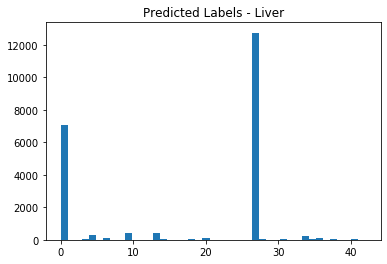

In [82]:
plt.hist(y_pred, 43)
plt.title('Predicted Labels - Liver')

In [50]:
desired_DDI = [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 18, 19, 20, 21, 22, 26, 28, 30, 31, 32, 38, 40, 41, 43, 44, 45,
               49, 50, 51, 52, 54, 55, 62, 67, 68, 72, 74, 76, 78, 79, 80, 81]
len(desired_DDI)
desired_DDI[27]

49

In [48]:
y_pred[1:10]

array([ 0, 27,  9, 27, 27, 27,  0,  0,  0])

In [61]:
def test_perf(best_model, ddi_df):
    # db id 
    ddi_df['drug1'] = [db_int(x) for x in ddi_df.drug_1_drugbank_id]
    ddi_df['drug2'] = [db_int(x) for x in ddi_df.drug_2_drugbank_id]
    ddi_df['Label'] = 1
    
    # filter output to only include DBs with similarity features
    ddi_df_output = ddi_df[ddi_df.drug1.isin(DB_to_index)]
    ddi_output = ddi_df_output[ddi_df_output.drug2.isin(DB_to_index)]

    # filter out the duplicate samples
    bool_series_to_delete = ddi_output[['drug1', 'drug2']].duplicated()
    ddi_clean = ddi_output[~bool_series_to_delete]
    
    # feature building
    # add similarity feature for each drug-drug pair
    n_similarity = 2159
    sim_array = np.empty([ddi_clean.shape[0], 2*n_similarity], dtype='float16')
    i = 0
    for index, (_, row) in enumerate(ddi_clean.iterrows()):
        if index % 10000 == 0:
            print("INFO: iter " + str(index + 1))
        drug1_index = DB_to_index[row["drug1"]]
        drug2_index = DB_to_index[row["drug2"]]
        feature_vec = np.hstack([drug_similarity.iloc[:,drug1_index],drug_similarity.iloc[:,drug2_index]])
        sim_array[index, ] = feature_vec
    
    # xgboost obj
    X_data = sim_array
    y_data = np.array(ddi_clean.Label)
    dtrain = xgb.DMatrix(X_data, label = y_data)
    
    # pred 
    y_pred = best_model.predict(dtrain)
    y_pred = np.asarray([np.argmax(line) for line in y_pred])
    
    output_dict = {'X_data': X_data,
                  'y_pred': y_pred
                  }
    return(output_dict)


In [62]:
renal_output = test_perf(bst_model, renal_ddi)

INFO: iter 1
INFO: iter 10001
INFO: iter 20001
INFO: iter 30001
INFO: iter 40001
INFO: iter 50001


In [63]:
heart_output = test_perf(bst_model, heart_ddi)

INFO: iter 1
INFO: iter 10001


In [64]:
neuro_output = test_perf(bst_model, neuro_ddi)

INFO: iter 1


Text(0.5, 1.0, 'Predicted Labels - Kidney')

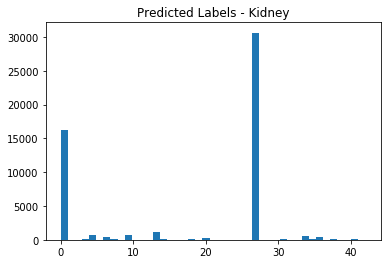

In [83]:
plt.hist(renal_output['y_pred'], 43)
plt.title('Predicted Labels - Kidney')

Text(0.5, 1.0, 'Predicted Labels - Heart')

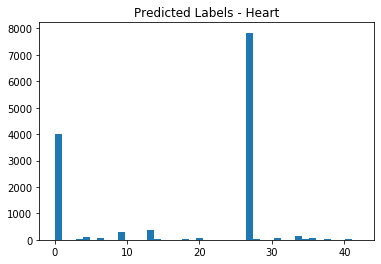

In [84]:
plt.hist(heart_output['y_pred'], 43)
plt.title('Predicted Labels - Heart')

Text(0.5, 1.0, 'Predicted Labels - Neuro')

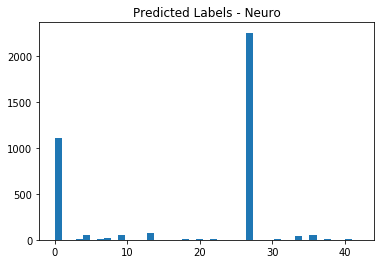

In [86]:
plt.hist(neuro_output['y_pred'], 43)
plt.title('Predicted Labels - Neuro')

Text(0.5, 1.0, 'Histogram of DDI Frequency - Liver ')

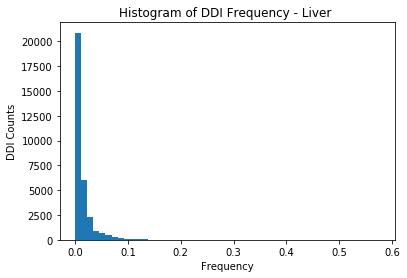

In [74]:
plt.hist(liver_ddi.mean_reporting_frequency, 50)
plt.xlabel('Frequency')
plt.ylabel('DDI Counts')
plt.title('Histogram of DDI Frequency - Liver ')

Text(0.5, 1.0, 'Histogram of DDI Frequency - Renal ')

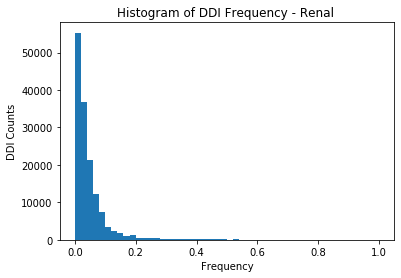

In [75]:
plt.hist(renal_ddi.mean_reporting_frequency, 50)
plt.xlabel('Frequency')
plt.ylabel('DDI Counts')
plt.title('Histogram of DDI Frequency - Renal ')

Text(0.5, 1.0, 'Histogram of DDI Frequency - Heart ')

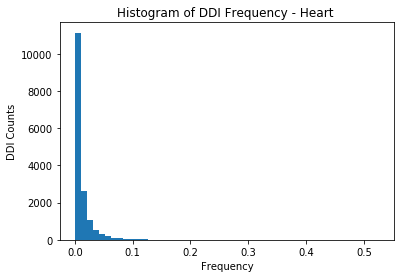

In [76]:
plt.hist(heart_ddi.mean_reporting_frequency, 50)
plt.xlabel('Frequency')
plt.ylabel('DDI Counts')
plt.title('Histogram of DDI Frequency - Heart ')

Text(0.5, 1.0, 'Histogram of DDI Frequency - Neuro ')

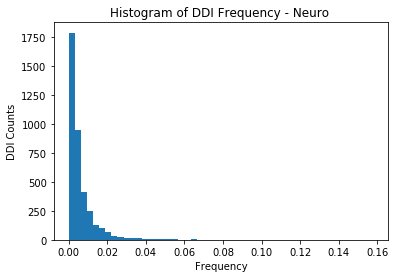

In [77]:
plt.hist(neuro_ddi.mean_reporting_frequency, 50)
plt.xlabel('Frequency')
plt.ylabel('DDI Counts')
plt.title('Histogram of DDI Frequency - Neuro ')

In [ ]:
plt.hist(liver_ddi.mean_reporting_frequency)

### Important Genes